https://www.kaggle.com/code/maricinnamon/automobile-customer-clustering-k-means-pca

In [1]:
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score #benzerlik skoru
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
df_test = pd.read_csv("test-set.csv")

df_train = pd.read_csv("train-set.csv")

In [5]:
df_test.head()

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Category 6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Category 6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Category 6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Category 6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Category 6


In [6]:
df_train.head()

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Category 6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6,A


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      2627 non-null   int64  
 1   Gender          2627 non-null   object 
 2   Married         2577 non-null   object 
 3   Age             2627 non-null   int64  
 4   Graduated       2603 non-null   object 
 5   Profession      2589 non-null   object 
 6   WorkExperience  2358 non-null   float64
 7   SpendingScore   2627 non-null   object 
 8   FamilySize      2514 non-null   float64
 9   Category        2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


In [15]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      8068 non-null   int64 
 1   Gender          8068 non-null   int64 
 2   Married         8068 non-null   int64 
 3   Age             8068 non-null   int64 
 4   Graduated       8068 non-null   int64 
 5   Profession      8068 non-null   int64 
 6   WorkExperience  8068 non-null   object
 7   SpendingScore   8068 non-null   int64 
 8   FamilySize      8068 non-null   object
 9   Category        8068 non-null   int64 
 10  Segmentation    8068 non-null   object
dtypes: int64(8), object(3)
memory usage: 693.5+ KB


In [9]:
df_train = df_train.fillna("Unknown")

In [14]:
df_train["Gender"] = pd.factorize(df_train["Gender"])[0]
df_train["Married"] = pd.factorize(df_train["Married"])[0]
df_train["Graduated"] = pd.factorize(df_train["Graduated"])[0]
df_train["Profession"] = pd.factorize(df_train["Profession"])[0]
df_train["SpendingScore"] = pd.factorize(df_train["SpendingScore"])[0]
df_train["Category"] = pd.factorize(df_train["Category"])[0]

In [17]:
df_train["WorkExperience"] = df_train["WorkExperience"].replace("Unknown",df_train["WorkExperience"].mode()[0])
df_train["FamilySize"] = df_train["FamilySize"].replace("Unknown",df_train["FamilySize"].mode()[0])

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)) # range is [0, 1]
normed = scaler.fit_transform(df_train.copy().drop(columns=["CustomerID", "Segmentation"]))

df_normed = pd.DataFrame(data=normed, columns=df_train.columns[1:-1])
df_normed.head()

,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,0.0,0.0,0.056338,0.0,0.000000,0.071429,0.0,0.375,0.000000
1,1.0,0.5,0.281690,0.5,0.111111,0.071429,0.5,0.250,0.000000
2,1.0,0.5,0.690141,0.5,0.111111,0.071429,0.0,0.000,0.142857
3,0.0,0.5,0.690141,0.5,0.222222,0.000000,1.0,0.125,0.142857
4,1.0,0.5,0.309859,0.5,0.333333,0.071429,1.0,0.625,0.142857


In [19]:
df_normed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          8068 non-null   float64
 1   Married         8068 non-null   float64
 2   Age             8068 non-null   float64
 3   Graduated       8068 non-null   float64
 4   Profession      8068 non-null   float64
 5   WorkExperience  8068 non-null   float64
 6   SpendingScore   8068 non-null   float64
 7   FamilySize      8068 non-null   float64
 8   Category        8068 non-null   float64
dtypes: float64(9)
memory usage: 567.4 KB


Verimizi clustering yapabilmek için normalize yaptık ve hepsini floata çevirdik

In [24]:
cols = df_normed.columns[:-1]
df_clust = df_normed[cols]
df_clust.insert(0, "CustomerID", df_train["CustomerID"])

In [25]:
df_clust

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize
0,462809,0.0,0.0,0.056338,0.0,0.000000,0.071429,0.0,0.375
1,462643,1.0,0.5,0.281690,0.5,0.111111,0.071429,0.5,0.250
2,466315,1.0,0.5,0.690141,0.5,0.111111,0.071429,0.0,0.000
3,461735,0.0,0.5,0.690141,0.5,0.222222,0.000000,1.0,0.125
4,462669,1.0,0.5,0.309859,0.5,0.333333,0.071429,1.0,0.625
...,...,...,...,...,...,...,...,...,...
8063,464018,0.0,0.0,0.056338,0.0,1.000000,0.000000,0.0,0.750
8064,464685,0.0,0.0,0.239437,0.0,0.555556,0.214286,0.0,0.375
8065,465406,1.0,0.0,0.211268,0.5,0.000000,0.071429,0.0,0.000
8066,467299,1.0,0.0,0.126761,0.5,0.000000,0.071429,0.0,0.375


number of cluster 2, silhouette 0.31820642254243253
number of cluster 3, silhouette 0.2679281037911465
number of cluster 4, silhouette 0.27594395321165666
number of cluster 5, silhouette 0.25941721467771706
number of cluster 6, silhouette 0.23631406411118486
number of cluster 7, silhouette 0.23984932778663468
number of cluster 8, silhouette 0.23171553496009129
number of cluster 9, silhouette 0.23271666182900463
number of cluster 10, silhouette 0.22555848418998847


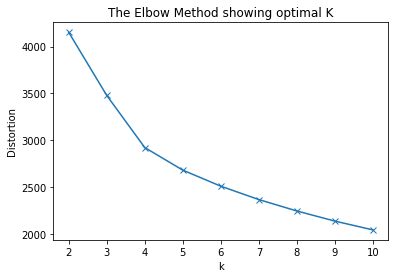

In [26]:
def cluster(x,clusters):
    allscore=[]
    allclusters=[]
    sum_of_squared_distances = []
    x=x
    for i in np.arange(1,clusters):

          i+=1
          model=KMeans(n_clusters=i)
          pred=model.fit_predict(x)
          s_score = silhouette_score(x,pred)
          score=silhouette_score(x,pred)
          print("number of cluster {}, silhouette {}".format(i,score))
          allscore.append(s_score)
          allclusters.append(i)
          sum_of_squared_distances.append(model.inertia_)

    plt.plot(allclusters,sum_of_squared_distances, marker='x')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing optimal K')
    plt.show()
cluster(df_normed,10)

In [27]:
model = KMeans(n_clusters = 4)

model = model.fit(df_clust)

pred = model.predict(df_clust)

In [28]:
df_clust["clust"] = pred
df_clust

c:\Users\oztur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,clust
0,462809,0.0,0.0,0.056338,0.0,0.000000,0.071429,0.0,0.375,3
1,462643,1.0,0.5,0.281690,0.5,0.111111,0.071429,0.5,0.250,3
2,466315,1.0,0.5,0.690141,0.5,0.111111,0.071429,0.0,0.000,1
3,461735,0.0,0.5,0.690141,0.5,0.222222,0.000000,1.0,0.125,3
4,462669,1.0,0.5,0.309859,0.5,0.333333,0.071429,1.0,0.625,3
...,...,...,...,...,...,...,...,...,...,...
8063,464018,0.0,0.0,0.056338,0.0,1.000000,0.000000,0.0,0.750,2
8064,464685,0.0,0.0,0.239437,0.0,0.555556,0.214286,0.0,0.375,2
8065,465406,1.0,0.0,0.211268,0.5,0.000000,0.071429,0.0,0.000,2
8066,467299,1.0,0.0,0.126761,0.5,0.000000,0.071429,0.0,0.375,1
